## Import Libraries

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, classification_report

## Load and Inspect Dataset

In [25]:
df = pd.read_csv("parkinson_disease.csv")
pd.set_option("display.max_columns", 10)

print("Sample Data:")
display(df.sample(5))

# Check for missing values
print("Total missing values:", df.isnull().sum().sum())

Sample Data:


,id,gender,PPE,DFA,RPDE,...,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
199,66,0,0.82407,0.79658,0.45866,...,2.8711,4.4712,4.3862,3.7338,1
398,132,0,0.83844,0.56677,0.31278,...,66.5518,38.3632,31.1193,9.4326,0
36,12,1,0.82004,0.74807,0.52028,...,4.4058,2.8555,3.1605,4.8342,1
431,143,1,0.82310,0.67967,0.49348,...,69.1727,58.7229,49.2435,96.2678,1
649,216,0,0.84056,0.65446,0.47962,...,4.4652,4.6952,7.6986,6.2858,0


Total missing values: 0


## Visualize Class Distribution

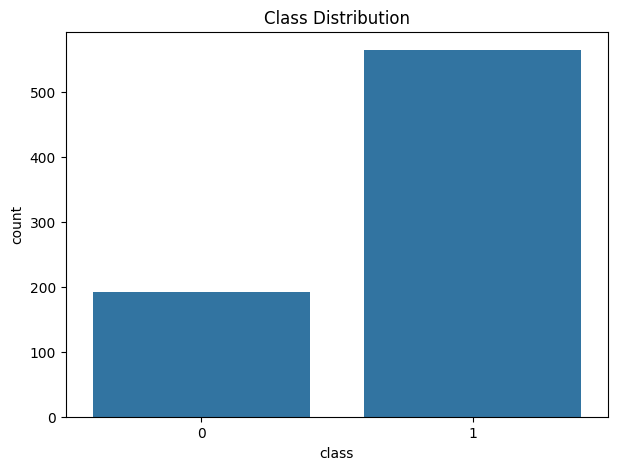

In [26]:
plt.figure(figsize=(7,5))
sns.countplot(data=df, x="class")
plt.title("Class Distribution")
plt.show()

## Data Preprocessing - Aggregation and Multicollinearity Handling

In [27]:
# Group by 'id' and take mean (handle duplicate rows per patient)
df = df.groupby("id").mean().reset_index()
df.drop("id", axis=1, inplace=True)

In [28]:
# Remove highly correlated features (corr > 0.7) to reduce multicollinearity
final_columns = []

for col in df.columns:
    if col == "class":
        continue

    keep = True
    for prev_col in final_columns:
        if df[col].corr(df[prev_col]) > 0.7:
            keep = False
            break

    if keep:
        final_columns.append(col)

final_columns.append("class")
df = df[final_columns]

print(f"Shape after removing correlated features: {df.shape}")

Shape after removing correlated features: (252, 287)


## Feature Scaling and Selection

In [29]:
X = df.drop("class", axis=1)
y = df["class"]

# Scale features to [0,1] range (needed for chi2 test)
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)
X_norm_df = pd.DataFrame(X_norm, columns=X.columns)

# Select top 30 features based on chi-squared test
selector = SelectKBest(chi2, k=30)
selector.fit(X_norm_df, y)

filtered_columns = selector.get_support()

filtered_data = X_norm_df.loc[:, filtered_columns].copy()
filtered_data["class"] = y.values

df = filtered_data
print(f"Shape after feature selection: {df.shape}")

Shape after feature selection: (252, 31)


## Train-Test Split and Handling Class Imbalance

In [30]:
X = df.drop("class", axis=1)
y = df["class"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)

# Use SMOTE for oversampling minority class on training data only
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Training shape:", X_train_resampled.shape)
print("Class distribution:\n", y_train_resampled.value_counts())

Training shape: (300, 30)
Class distribution:
 class
1.0    150
0.0    150
Name: count, dtype: int64


## Train Models and Evaluate with ROC AUC

In [32]:
models = [
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    XGBClassifier(eval_metric='logloss', random_state=42),
    SVC(kernel='rbf', probability=True, random_state=42)
]

for model in models:
    model_name = model.__class__.__name__
    print(f"\nTraining {model_name}...")

    model.fit(X_train_resampled, y_train_resampled)

    # For ROC AUC, get prediction probabilities if possible
    if hasattr(model, "predict_proba"):
        train_probs = model.predict_proba(X_train_resampled)[:, 1]
        val_probs = model.predict_proba(X_val)[:, 1]
    else:
        # For SVC decision_function gives distance to decision boundary
        train_probs = model.decision_function(X_train_resampled)
        val_probs = model.decision_function(X_val)

    print(f'Train ROC AUC Score: {roc_auc_score(y_train_resampled, train_probs):.4f}')
    print(f'Validation ROC AUC Score: {roc_auc_score(y_val, val_probs):.4f}')


Training LogisticRegression...
Train ROC AUC Score: 0.8917
Validation ROC AUC Score: 0.7996

Training XGBClassifier...
Train ROC AUC Score: 1.0000
Validation ROC AUC Score: 0.9190

Training SVC...
Train ROC AUC Score: 0.9332
Validation ROC AUC Score: 0.8583


## Confusion Matrix and Classification Report for SVC Model

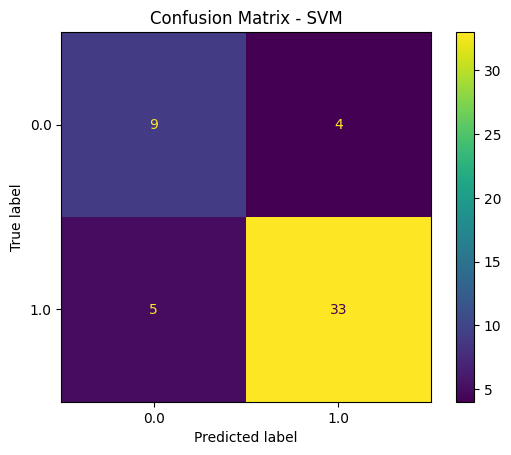

Classification Report - SVM:

              precision    recall  f1-score   support

         0.0       0.64      0.69      0.67        13
         1.0       0.89      0.87      0.88        38

    accuracy                           0.82        51
   macro avg       0.77      0.78      0.77        51
weighted avg       0.83      0.82      0.83        51



In [37]:
best_model = models[2]  # SVM

ConfusionMatrixDisplay.from_estimator(best_model, X_val, y_val)
plt.title("Confusion Matrix - SVM")
plt.show()

print("Classification Report - SVM:\n")
print(classification_report(y_val, best_model.predict(X_val)))